In [4]:
pip install pyedflib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
def search_annotations_edf(dirname):
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith("Hypnogram.edf")]
    return filenames

def search_signals_edf(dirname):
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith("PSG.edf")]
    return filenames

def search_correct_annotations(dirname,filename):
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filename = [file for file in file_list if search_filename in file if file.endswith("Hypnogram.edf")]
    
    return filename

def search_signals_npy(dirname):
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith(".npy")]
    return filenames

def search_correct_annotations_npy(dirname,filename):
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filename = [file for file in file_list if search_filename in file if file.endswith("npy")]
    
    return filename

def search_correct_signals_npy(dirname,filename):
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filename = [file for file in file_list if search_filename in file if file.endswith("npy")]
    
    return filename

In [6]:
import os
import numpy as np
from pyedflib import highlevel

def search_correct_annotations(signal_path, filename):
    """Find the corresponding annotation file for a given signal file."""
    base_filename = filename.split('-')[0] + filename.split('-')[1][:2] + 'EC-Hypnogram.edf'
    annotations = [f for f in os.listdir(signal_path) if f == base_filename]
    return annotations

path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/' 
annotations_edf_list = search_annotations_edf(path)
signals_edf_list = search_signals_edf(path)

print('signals edf file list')
print(signals_edf_list)

print('annotations edf file list')
print(annotations_edf_list)

signals edf file list
['SC4001E0-PSG.edf', 'SC4002E0-PSG.edf', 'SC4011E0-PSG.edf', 'SC4012E0-PSG.edf', 'SC4021E0-PSG.edf', 'SC4022E0-PSG.edf', 'SC4031E0-PSG.edf', 'SC4032E0-PSG.edf', 'SC4041E0-PSG.edf', 'SC4042E0-PSG.edf', 'SC4051E0-PSG.edf', 'SC4052E0-PSG.edf', 'SC4061E0-PSG.edf', 'SC4062E0-PSG.edf', 'SC4071E0-PSG.edf', 'SC4072E0-PSG.edf', 'SC4081E0-PSG.edf', 'SC4082E0-PSG.edf', 'SC4091E0-PSG.edf', 'SC4092E0-PSG.edf', 'SC4101E0-PSG.edf', 'SC4102E0-PSG.edf', 'SC4111E0-PSG.edf', 'SC4112E0-PSG.edf', 'SC4121E0-PSG.edf', 'SC4122E0-PSG.edf', 'SC4131E0-PSG.edf', 'SC4141E0-PSG.edf', 'SC4142E0-PSG.edf', 'SC4151E0-PSG.edf', 'SC4152E0-PSG.edf', 'SC4161E0-PSG.edf', 'SC4162E0-PSG.edf', 'SC4171E0-PSG.edf', 'SC4172E0-PSG.edf', 'SC4181E0-PSG.edf', 'SC4182E0-PSG.edf', 'SC4191E0-PSG.edf', 'SC4192E0-PSG.edf', 'SC4201E0-PSG.edf', 'SC4202E0-PSG.edf', 'SC4211E0-PSG.edf', 'SC4212E0-PSG.edf', 'SC4221E0-PSG.edf', 'SC4222E0-PSG.edf', 'SC4231E0-PSG.edf', 'SC4232E0-PSG.edf', 'SC4241E0-PSG.edf', 'SC4242E0-PSG.edf

In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

fs = 100
epoch_size = 30
# CPU에서 실행하도록 설정
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 데이터 경로 설정
path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/Fpz-Cz/'
annotations_path =  '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/annotations/'

# 파일 리스트 가져오기
signals_npy_list = search_signals_npy(path)

# 데이터 로드 및 전처리
X = []
y = []

for filename in signals_npy_list:
    signals = np.load(os.path.join(path, filename))
    label_filename = search_correct_signals_npy(annotations_path, filename)[0]
    labels = np.load(os.path.join(annotations_path, label_filename))

    # 신호 데이터를 (샘플 수, 데이터 길이) 형태로 변환
    num_samples = len(labels)
    signals = signals.reshape(-1, fs * epoch_size)

    # 레이블이 5인 데이터를 제거하고, 레이블 매핑
    valid_idx = labels != 5
    signals = signals[valid_idx]
    labels = labels[valid_idx]
    
    labels = np.where(labels <= 1, 0, np.where(labels <= 3, 1, 2))  # 6개 레이블을 3개로 매핑
    
    X.append(signals)
    y.append(labels)

X = np.concatenate(X, axis=0)  # 전체 데이터를 하나로 합치기
y = np.concatenate(y, axis=0)  # 전체 레이블을 하나로 합치기

# 데이터 형태 변환 (N, 3000, 1)
X = X.reshape(-1, 3000, 1)
y = to_categorical(y, num_classes=3)  # One-hot 인코딩 (3개 클래스)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN 모델 정의
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(3000, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3개 클래스
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 학습 결과 출력
print(f"Train Accuracy: {model.evaluate(X_train, y_train)[1]}")
print(f"Test Accuracy: {model.evaluate(X_test, y_test)[1]}")

2024-07-07 12:47:27.352683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 12:47:27.352774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 12:47:27.352806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 12:47:27.361129: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 12:48:28.559013: I tensor

Epoch 1/10


2024-07-07 12:49:05.368664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-07-07 12:49:06.352441: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9e135a6df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-07 12:49:06.352507: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-07-07 12:49:06.352514: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-07-07 12:49:06.357961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-07 12:49:06.445289: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10374/10374 [==============================] - 36s 3ms/step - loss: 0.3701 - accuracy: 0.8703 - val_loss: 0.3034 - val_accuracy: 0.8698
Epoch 2/10
10374/10374 [==============================] - 31s 3ms/step - loss: 0.2767 - accuracy: 0.8876 - val_loss: 0.3247 - val_accuracy: 0.8698
Epoch 3/10
10374/10374 [==============================] - 32s 3ms/step - loss: 0.2578 - accuracy: 0.8954 - val_loss: 0.2690 - val_accuracy: 0.8894
Epoch 4/10
10374/10374 [==============================] - 31s 3ms/step - loss: 0.2444 - accuracy: 0.9006 - val_loss: 0.2863 - val_accuracy: 0.8847
Epoch 5/10
10374/10374 [==============================] - 32s 3ms/step - loss: 0.2340 - accuracy: 0.9047 - val_loss: 0.2728 - val_accuracy: 0.8910
Epoch 6/10
10374/10374 [==============================] - 31s 3ms/step - loss: 0.2229 - accuracy: 0.9091 - val_loss: 0.2800 - val_accuracy: 0.8909
Epoch 7/10
10374/10374 [==============================] - 31s 3ms/step - loss: 0.2146 - accuracy: 0.9132 - val_loss: 0.3367 - val

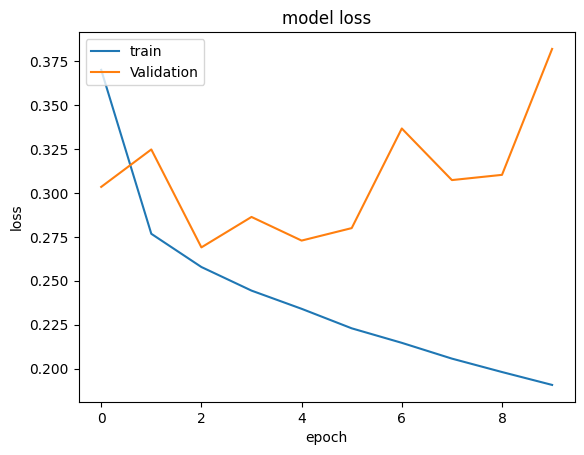

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

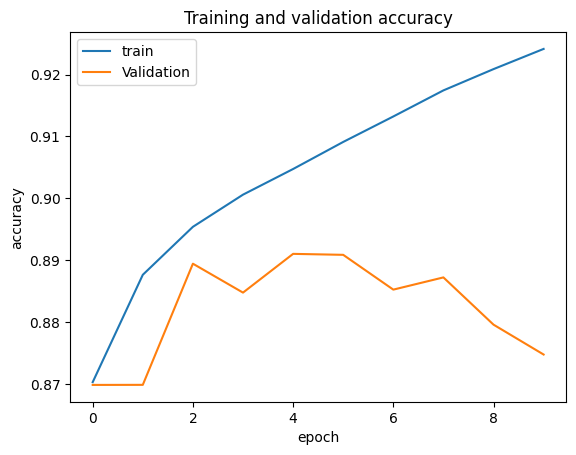

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# 모델 예측
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)

# 평가 결과 출력
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Classification Report:')
print(classification_report(y_true, y_pred))




2594/2594 [==============================] - 3s 1ms/step
f1_score =  0.8638297957267096
Accuracy: 0.8747364235537937
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     61370
           1       0.69      0.93      0.79     16324
           2       0.42      0.13      0.20      5299

    accuracy                           0.87     82993
   macro avg       0.69      0.66      0.64     82993
weighted avg       0.87      0.87      0.86     82993



In [13]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(3000, 1)),  # LSTM 층 추가
    LSTM(32),  # 추가 LSTM 층
    Dropout(0.5),
    Dense(3, activation='softmax')  # 출력층
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/6
10374/10374 [==============================] - 2685s 259ms/step - loss: 0.5746 - accuracy: 0.7853 - val_loss: 0.5300 - val_accuracy: 0.7781
Epoch 2/6
10374/10374 [==============================] - 2677s 258ms/step - loss: 0.5003 - accuracy: 0.8075 - val_loss: 0.3464 - val_accuracy: 0.8698
Epoch 3/6
10374/10374 [==============================] - 2673s 258ms/step - loss: 0.4378 - accuracy: 0.8382 - val_loss: 0.6558 - val_accuracy: 0.7395
Epoch 4/6
10374/10374 [==============================] - 2681s 258ms/step - loss: 0.4610 - accuracy: 0.8204 - val_loss: 0.3527 - val_accuracy: 0.8680
Epoch 5/6
10374/10374 [==============================] - 2688s 259ms/step - loss: 0.3484 - accuracy: 0.8658 - val_loss: 0.2715 - val_accuracy: 0.8868
Epoch 6/6
10374/10374 [==============================] - 2687s 259ms/step - loss: 0.4059 - accuracy: 0.8498 - val_loss: 0.3388 - val_accuracy: 0.8678


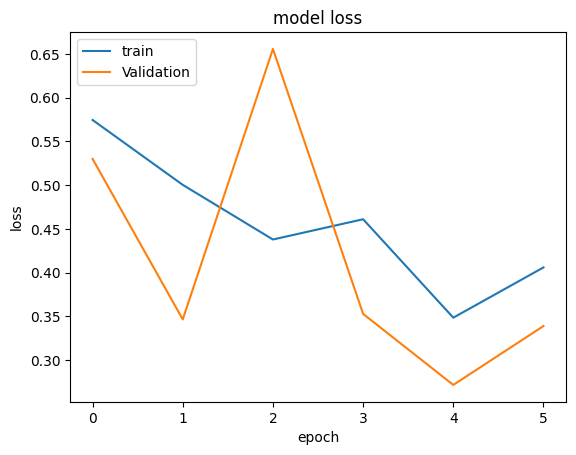

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

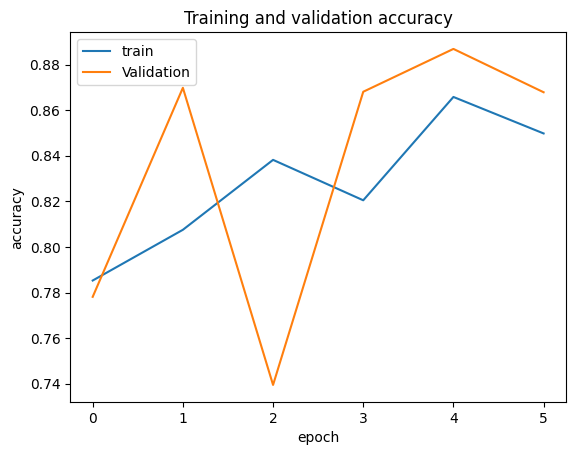

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# 모델 예측
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)

# 평가 결과 출력
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Classification Report:')
print(classification_report(y_true, y_pred))




2594/2594 [==============================] - 284s 109ms/step
f1_score =  0.8437979736959611
Accuracy: 0.8678322268143096
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     61370
           1       0.67      0.91      0.77     16324
           2       0.00      0.00      0.00      5299

    accuracy                           0.87     82993
   macro avg       0.54      0.61      0.57     82993
weighted avg       0.83      0.87      0.84     82993



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 데이터 경로 설정
path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/Fpz-Cz/'
annotations_path =  '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/annotations/'

# 파일 리스트 가져오기
signals_npy_list = search_signals_npy(path)

# 데이터 로드 및 전처리
X = []
y = []

for filename in signals_npy_list:
    signals = np.load(os.path.join(path, filename))
    label_filename = search_correct_signals_npy(annotations_path, filename)[0]
    labels = np.load(os.path.join(annotations_path, label_filename))

    # 신호 데이터를 (샘플 수, 데이터 길이) 형태로 변환
    num_samples = len(labels)
    signals = signals.reshape(-1, fs * epoch_size)

    # 레이블이 5인 데이터를 제거하고, 레이블 매핑
    valid_idx = labels != 5
    signals = signals[valid_idx]
    labels = labels[valid_idx]
    
    labels = np.where(labels <= 1, 0, np.where(labels <= 3, 1, 2))  # 6개 레이블을 3개로 매핑
    
    X.append(signals)
    y.append(labels)

X = np.concatenate(X, axis=0)  # 전체 데이터를 하나로 합치기
y = np.concatenate(y, axis=0)  # 전체 레이블을 하나로 합치기



In [ ]:
X.shape

In [ ]:
y.shape

In [20]:
import os
import numpy as np
import pandas as pd

# 데이터 경로 설정
path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/Fpz-Cz/'
annotations_path =  '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/annotations/'

# 파일 리스트 가져오기
signals_npy_list = search_signals_npy(path)

# 데이터 로드 및 전처리
X = []
y = []

for filename in signals_npy_list:
    signals = np.load(os.path.join(path, filename))
    label_filename = search_correct_signals_npy(annotations_path, filename)[0]
    labels = np.load(os.path.join(annotations_path, label_filename))
    
    X.append(signals)
    y.append(labels)

X = np.concatenate(X, axis=1)  # 전체 데이터를 하나로 합치기
y = np.concatenate(y, axis=0)  # 전체 레이블을 하나로 합치기

# 데이터 형태 변환 (N, 3000)
X = X.reshape(-1, 3000)
y = y.reshape(-1, 1)  # 레이블을 2차원 형태로 변환

# 데이터프레임으로 변환
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y, columns=["label"])

# 데이터프레임 확인
print(df_X.head())
print(df_y.head())

        0          1          2          3          4          5     \
0   5.016850  -2.578755   1.359707  -2.391209  -5.204396  -7.454945   
1  11.299634  18.145055  18.801465  17.301099  13.831502   6.610989   
2  13.362637  10.736996   6.329670   6.892308   4.454212  18.238828   
3  -1.922344  -1.078388  -2.766300   3.422711   0.703297   8.111355   
4  12.987546  16.175824  14.863004   6.986081  11.018315   4.547985   

        6          7          8          9     ...       2990       2991  \
0  -8.298901  -6.892308  -3.704029  -0.984615  ...  47.027106  37.649817   
1   7.454945   7.454945   7.267399   8.486447  ...  12.331136   0.797070   
2  12.143590  13.925275   8.486447   7.548718  ...  16.926007  15.519414   
3  -1.734799  -2.297436  -2.109890  -9.705495  ...  18.801465  10.549451   
4  -2.766300 -18.895238 -14.581685 -17.207326  ...  30.523077  22.083516   

        2992       2993       2994       2995       2996       2997  \
0  35.211722  33.898901  26.959707  33.148718

In [22]:
import os
import numpy as np
import pandas as pd

# 데이터 경로 설정
path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/Fpz-Cz/'
annotations_path = '/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/origin_npy/annotations/'

# 파일 리스트 가져오기
signals_npy_list = search_signals_npy(path)

# 데이터 로드 및 전처리
X = []
y = []

for filename in signals_npy_list:
    signals = np.load(os.path.join(path, filename))
    label_filename = search_correct_signals_npy(annotations_path, filename)[0]
    labels = np.load(os.path.join(annotations_path, label_filename))
    
    X.append(signals)
    y.append(labels)

X = np.concatenate(X, axis=1)  # 전체 데이터를 하나로 합치기
y = np.concatenate(y, axis=0)  # 전체 레이블을 하나로 합치기

# 데이터 형태 변환 (N, 3000)
X = X.reshape(-1, 3000)
y = y.reshape(-1, 1)  # 레이블을 2차원 형태로 변환

# 컬럼명 생성 (0초부터 30초까지의 샘플링 포인트)
fs = 100  # Sampling rate
columns = [f"t_{i/fs:.2f}s" for i in range(3000)]

# 데이터프레임으로 변환
df_X = pd.DataFrame(X, columns=columns)
df_y = pd.DataFrame(y, columns=["label"])

# 각 레이블의 수 세기
label_counts = df_y['label'].value_counts()
print(label_counts)

0    285433
2     69132
4     25835
1     21522
3     13039
5      1463
Name: label, dtype: int64
